In [1]:
from collections import OrderedDict
import sys
from pathlib import Path
import json
import time
import math

import numpy as np
import matplotlib.pyplot as plt

import cv2

import kornia

import torch
import torch.nn as nn

import torchvision as tv
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import functional as tfunc

sys.path.append('../mine_soar')
import MalmoPython
from utils import draw_image, draw_layers

In [2]:
MISSION_PORT = 9001
VIDEO_SHAPE = (128, 128)
VIDEO_DEPTH = 3
DEVICE = 'cuda:0'
# DEVICE = 'cpu'
torch.autograd.set_detect_anomaly(True)

In [3]:
MALMO_HOST = MalmoPython.AgentHost()
malmo_client_info = MalmoPython.ClientInfo('127.0.0.1', MISSION_PORT)
malmo_client_pool = MalmoPython.ClientPool()
malmo_client_pool.add(malmo_client_info)

In [4]:
def start_mission(file="random_world.xml"):
    MALMO_HOST.sendCommand("quit")
    while MALMO_HOST.getWorldState().is_mission_running:
        time.sleep(0.1)
    time.sleep(1)
    mission_file = Path(file)
    random_world_mission_spec = MalmoPython.MissionSpec(mission_file.read_text(), True)
    random_world_record_spec = MalmoPython.MissionRecordSpec()
    MALMO_HOST.startMission(random_world_mission_spec, 
                                  malmo_client_pool,
                                  random_world_record_spec,
                                  0,
                                  "TEST ALPHA")

In [5]:
class FeatureExtractor(nn.Module):
    def __init__(self, fpn_dim=256):
        super().__init__()
        self.num_fpn_stages = 4
        self.fpn_dim = fpn_dim
        self.fpn = tv.ops.FeaturePyramidNetwork(
            in_channels_list=[256, 512, 1024, 2048], out_channels=fpn_dim
        )
        self.feat_extender_1 = nn.Sequential(
            nn.ConvTranspose2d(fpn_dim, fpn_dim, 8, 4, 2),
            nn.BatchNorm2d(fpn_dim),
            nn.Conv2d(fpn_dim, fpn_dim, 4, 2, 1),
            nn.BatchNorm2d(fpn_dim),
            nn.Conv2d(fpn_dim, fpn_dim, 3, 1, 1),
            nn.BatchNorm2d(fpn_dim),
            nn.ReLU(inplace=True)
        )
        self.downscaler = nn.Sequential(
            nn.Conv2d(VIDEO_DEPTH, fpn_dim, 4, 2, 1),
            nn.BatchNorm2d(fpn_dim),
            nn.Conv2d(fpn_dim, fpn_dim, 7, 1, 3),
            nn.BatchNorm2d(fpn_dim),
            nn.Conv2d(fpn_dim, fpn_dim, 3, 1, 1),
            nn.BatchNorm2d(fpn_dim),
            nn.ReLU(inplace=True)
        )
        self.feat_extender_2 = nn.Sequential(
            nn.ConvTranspose2d(fpn_dim, fpn_dim, 4, 2, 1),
            nn.BatchNorm2d(fpn_dim),
            nn.Conv2d(fpn_dim, fpn_dim, 3, 1, 1),
            nn.BatchNorm2d(fpn_dim),
            nn.Conv2d(fpn_dim, fpn_dim, 3, 1, 1),
            nn.BatchNorm2d(fpn_dim),
            nn.ReLU(inplace=True)
        )
        
        self.activation = {}
#         self.resnet50_backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet50_backbone = resnet50()
        self.resnet50_backbone.conv1 = nn.Conv2d(VIDEO_DEPTH, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # self.resnet50_backbone.layer1.register_forward_hook(self.get_activation('conv2'))
        # self.resnet50_backbone.layer2.register_forward_hook(self.get_activation('conv3'))
        # self.resnet50_backbone.layer3.register_forward_hook(self.get_activation('conv4'))
        # self.resnet50_backbone.layer4.register_forward_hook(self.get_activation('conv5'))
        
        # self.fpn_stage_1 = nn.Conv2d(2048, self.fpn_dim, kernel_size=1)
        # self.fpn_stage_2 = FPNStage(self.fpn_dim, 1024)
        # self.fpn_stage_3 = FPNStage(self.fpn_dim, 512)
        # self.fpn_stage_4 = FPNStage(self.fpn_dim, 256)
        
    def forward(self, input):
        out = self.resnet50_backbone.conv1(input)
        out = self.resnet50_backbone.bn1(out)
        out = self.resnet50_backbone.relu(out)
        out = self.resnet50_backbone.maxpool(out)
        
        feat0 = self.resnet50_backbone.layer1(out)
        feat1 = self.resnet50_backbone.layer2(feat0)
        feat2 = self.resnet50_backbone.layer3(feat1)
        feat3 = self.resnet50_backbone.layer4(feat2)

        feats = OrderedDict()
        feats["0"] = feat0
        feats["1"] = feat1
        feats["2"] = feat2
        feats["3"] = feat3

        extracted_feats = self.fpn(feats)['0']        
        out_feats = self.feat_extender_1(extracted_feats)
        
#         downscaled_input = self.downscaler(input)
#         out_feats = out_feats + downscaled_input
#         out_feats = self.feat_extender_2(out_feats)
        # dense_feats = out_feats["3"]
        # flat_feats = self.resnet.avgpool(dense_feats)
        # flat_feats = torch.flatten(flat_feats, 1)


        # fpn_stage_1_output = self.fpn_stage_1(self.activation['conv5'])
        # fpn_stage_2_output = self.fpn_stage_2(self.activation['conv4'], fpn_stage_1_output)
        # fpn_stage_3_output = self.fpn_stage_3(self.activation['conv3'], fpn_stage_2_output)
        # fpn_stage_4_output = self.fpn_stage_4(self.activation['conv2'], fpn_stage_3_output)

        return out_feats
#         return out_feats["0"]

feat_extractor = FeatureExtractor().to(DEVICE)

In [ ]:
feat_extractor.resnet50_backbone

In [6]:
def get_mc_img(show=False, transform=None):
    state = MALMO_HOST.getWorldState()
    while state.number_of_video_frames_since_last_state < 1 or state.number_of_observations_since_last_state < 1:
        time.sleep(0.1)
        state = MALMO_HOST.getWorldState()
    image = np.frombuffer(state.video_frames[0].pixels, dtype=np.uint8)
    image = image.reshape(VIDEO_SHAPE+(4,))
    
    if VIDEO_DEPTH == 3:
        image = image[:,:,:3]
    image_tensor = tfunc.to_tensor(image).to(DEVICE).unsqueeze(0)
    if transform:
        image_tensor = transform(image_tensor)
    
    obs = json.loads(state.observations[0].text)
    x = obs['XPos']
    y = obs['YPos']
    z = obs['ZPos']
    pitch = obs['Pitch']
    yaw = obs['Yaw']
    world_time = obs['WorldTime']
    life_time = obs['TimeAlive']
    agent_data = np.array([x, y, z, pitch, yaw, world_time, life_time]).astype(np.float32)
    agent_data_tensor = torch.Tensor(agent_data).to(DEVICE)
    
    if show:
        plt.imshow(image)
        plt.show()
        plt.close()
    return image, image_tensor, agent_data_tensor

In [ ]:
# start_mission()

In [ ]:
# img, img_tens, agent_data = get_mc_img(True)

In [ ]:
# feats = feat_extractor(img_tens)
# print(feats.shape)

## Invariant I want to capture: Visual continuity/cohesion
That is, as the camera and world move, idetnify visual regions of the image which move together. As the agent walks by a particular tree, e.g., the specific pixels which display the tree will change, and the exact image of the tree will change slightly, but the general shape, color, and texture, as well as the spatial alignment of these, should remain laregly invariant.  System should learn to generate features which remain invariant across frames *accounting for self/camera movement*. 
  
## Learning Strategy
Without ground truth voxel alignment (which Malmo doesn't seem to be able to provide easily), how do I measure the efficacy of the model? 

One answer: prediction of the feature map of the next vision frame, given the next movement of the camera. This is nice because it can be learned online and unsupervised, but it isn't guaranteed to not collapse into uselessness. 
- One failure mode might be it learning a constant output so that it's future prediction is always correct. Would need to experiment to see if this happens and, if it does, how to avoid it.
 - A possible solution to this particular failure mode might be trying to force the difference (distance?) between the two feature maps to linearly correlate with the distance between the two raw image frames. It seems reasonable that the relative change in the feature maps should be proportional to the relative change in the base images
 - Another solution I'll use in Proposal 1 below is to use the feature maps as visual encodings and verify that the decoded feature maps looks like the vision. This ensures the features have to track *something* in the world and can't be wholly made up

### Proposal 1:
1. Use FPN extractor above to get feature maps of the previous vision frame and current vision frame
2. Use a predictor model to generate a predicted next feature map from the previous frame feature map and the camera movement.
3. Minimize the pixel-to-pixel difference between the true and predicted current frame feature maps
4. Use a decoder model on the predicted feature map and minimize the difference between its output and the current vision

What, fundamentally, does Prop. 1 learn, assuming pixel alignment works as expected? It learns to generate features which can be transformed, given knowledge of camera movement, into an encoding of the future visual input that matches both the future input's own encoding and can be decoded into an image that matches the raw future vision itself. Might call it a predictive auto-encoder or something. 

**Reasoning for belief that this will produce segmentation-relevant features**: given any camera movement, the images produced pre- and post-movement will differ based on *both* the camera transformation *and* the environment around the camera. Grant the simplifying assumption that objects are *cohesive*, meaning that the parts of an object (atoms, moleucules, bricks, body parts) share a common coordinate system and that, therefore, movement of the object as a whole moves each part of the object equally. Since any given camera movement is perceptually identical to the camera remaining fixed and the world moving in the opposite way (e.g., translating the camera left is perceptually identical to translating the world right), and since we're assuming objects are cohesive as explained above, we know that after a camera movement, each object in the world will have moved uniformly in the opposite way. The camera movement itself will also not have induced a change in the nature of the objects themselves, meaning their appearances will be the same as before the move. Assuming that the objects themselves won't move, the perceptual change in a particular object (including where it will appear in the field of view) given a particular camera movement is deterministic. Additionally, the each object will move uniquely due to parallax (at least in general and across multiple movements). Therefore, in order for the agent to effecetively predict what the post-movement image will look like based on the pre-movement image and the future movement, it needs to know:
1. How to shift what it is currently seeing according to the camera movement, and
2. what any newly-revealed pixels will look like

Since, *in a 3D environment*, the perceptual appearance of different objectes will move and scale at different speeds, the first of the above requires knowing how to shift each object, and that, in turn, requires knowing the perceptual extent of each object, aka its segmention.

#### Components
- Feature extractor network
 - Serviceable for now
- Prediction network
 - Needs to take feature map **&** camera movement as input, should output another feature map.
 - Should transform input feature map into output map according to camera movement
- Loss function minimizing difference between two feature maps (predicted and true)
- Decoder model going from feature map to rgb image
- Loss function minimizing difference between two rgb images (predicted and true)

#### Amendments
Might want a summarizer network which reduces the feature map to a much smaller representation, and *then* apply a prediction network and decoder that. Essentially an intermediate AE for the feature maps.

In [ ]:
# frame_1 = get_mc_img(False)
# img_1, img_tens_1, agent_data_1 = frame_1

In [ ]:
# MALMO_HOST.sendCommand("turn -0.1")
# time.sleep(1)

In [ ]:
# MALMO_HOST.sendCommand("turn 0")

In [ ]:
# frame_2 = get_mc_img(False)
# img_2, img_tens_2, agent_data_2 = frame_2

# camera_diff = agent_data_2 - agent_data_1
# print(camera_diff)

In [ ]:
# expanded = camera_diff.expand(1, 256, 256, 7).transpose(2,3).transpose(1,2).to(DEVICE)

In [ ]:
# feats_1 = feat_extractor(img_tens_1)

In [ ]:
# combined = torch.concat([feats_1, expanded], dim=1)
# combined.shape

In [ ]:
# test_conv = nn.Conv2d(263, 64, 3, 1, 5, dilation=5, padding_mode='reflect').to(DEVICE)
# test_conv(combined).shape

In [ ]:
# class Predictor(nn.Module):
#     def __init__(self, in_dims):
#         super().__init__()
        
#         self.conv1 = nn.Conv2d(in_dims, 256, 3, 1, 1, dilation=1, padding_mode='reflect')
#         self.conv2 = nn.Conv2d(in_dims, 256, 5, 1, 6, dilation=3, padding_mode='reflect')
#         self.conv3 = nn.Conv2d(in_dims, 256, 7, 1, 15, dilation=5, padding_mode='reflect')
#         self.conv4 = nn.Conv2d(in_dims, 256, 9, 1, 28, dilation=7, padding_mode='reflect')
        
#         self.bn4 = nn.BatchNorm2d(256)
#         self.relu4 = nn.ReLU()
        
#         self.conv5 = nn.Conv2d(256, 256, 3, 1, 1)
#         self.bn5 = nn.BatchNorm2d(256)
#         self.relu5 = nn.ReLU()
        
#         self.conv6 = nn.Conv2d(256, 256, 1, 1, 0)
#         self.bn6 = nn.BatchNorm2d(256)
#         self.relu6 = nn.ReLU()
        
#     def forward(self, x):
#         y_a = self.conv1(x)
#         y_b = self.conv2(x)
#         y_c = self.conv3(x)
#         y_d = self.conv4(x)
        
#         y = y_a + y_b + y_c + y_d
#         y = self.bn4(y)
#         y = self.relu4(y)
        
#         y = self.conv5(y)
#         y = self.bn5(y)
#         y = self.relu5(y)
        
#         y = self.conv6(y)
#         y = self.bn6(y)
#         y = self.relu6(y)
        
#         return y
    
# pred = Predictor(263).to(DEVICE)

In [7]:
class Predictor(nn.Module):
    def __init__(self, in_dims, conv_size=8):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_dims, 64, 1, 1, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, conv_size, 1, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 256, 1, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(256, 128, 1, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, conv_size, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 512, 1, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(512, 256, 1, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, conv_size, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 1024, 1, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, 1, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, conv_size, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 512, 1, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        self.block5 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 1, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 128, conv_size, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 256, 1, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.block6 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 1, 1, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, conv_size, 1, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 256, 1, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
    def forward(self, x):
        y = self.block1(x)
        y = self.block2(y)
        y = self.block3(y)
        y = self.block4(y)
        y = self.block5(y)
        y = self.block6(y)
        return y
    
pred = Predictor(263).to(DEVICE)

In [ ]:
test_tens = torch.Tensor(np.random.random((1,263,64,64))).to(DEVICE)
test_pred = pred(test_tens)
print(test_pred.shape)

In [ ]:
# test_conv = nn.Conv2d(263, 256, 9, 1, 28, dilation=7, padding_mode='reflect').to(DEVICE)
# test_conv(test_tens).shape

In [8]:
class Decoder(nn.Module):
    def __init__(self, conv_size=8, num_condensers=3, mid_layers=3, out_img_size=VIDEO_SHAPE[0]):
        super().__init__()
        
        self.condensers = []
        pre_dims = 256
        for i in range(num_condensers):
            mid_dims = pre_dims//2
            post_dims = pre_dims*2
            cond = nn.Sequential(
                nn.Conv2d(pre_dims, mid_dims, 1, 1, 0, bias=False),
                nn.BatchNorm2d(mid_dims),
                nn.Conv2d(mid_dims, mid_dims, conv_size, 1, 0, bias=False),
                nn.BatchNorm2d(mid_dims),
                nn.Conv2d(mid_dims, post_dims, 1, 1, 0, bias=False),
                nn.BatchNorm2d(post_dims),
                nn.ReLU(),
                nn.MaxPool2d(2)            
            )
            self.add_module(f"condenser{i}", cond)
            self.condensers.append(cond)
            pre_dims = post_dims
            
        self.flatten = nn.Flatten(start_dim=1, end_dim=3)
        
        self.center = nn.RNN(post_dims, post_dims, mid_layers, bias=False, nonlinearity='relu')
        self.hx = torch.zeros((mid_layers, post_dims)).to(DEVICE)
        
        self.unflatten = nn.Unflatten(1, (post_dims, 1, 1))
        
        self.projectors = []
        for i in range(int(math.log(out_img_size,2))):
            mid_dims = pre_dims//4
            post_dims = pre_dims//2
            proj = nn.Sequential(
                nn.Conv2d(pre_dims, mid_dims, 1, 1, 0, bias=False),
                nn.ConvTranspose2d(mid_dims, mid_dims, conv_size, 2, conv_size//2-1, bias=False),
                nn.BatchNorm2d(mid_dims),
                nn.Conv2d(mid_dims, post_dims, 1, 1, 0, bias=False),
                nn.BatchNorm2d(post_dims),
                nn.ReLU()      
            )
            self.add_module(f"projector{i}", proj)
            self.projectors.append(proj)
            pre_dims = post_dims
            
        self.color = nn.Sequential(
            nn.Conv2d(post_dims, VIDEO_DEPTH, 1, 1, 0, bias=False),
            nn.BatchNorm2d(VIDEO_DEPTH),
            nn.Hardsigmoid()
        )
            
    def forward(self, x, hx=None):
        for cond in self.condensers:
            x = cond(x)
        x = self.flatten(x)
        
        if hx is not None:
            x, hx = self.center(x, hx)
        else:
            x, hx = self.center(x)
        hx.detach()
        
        x = self.unflatten(x)
        for proj in self.projectors:
            x = proj(x)
        x = self.color(x)
        
        return x, hx

decoder = Decoder().to(DEVICE)

In [ ]:
test_tens = torch.Tensor(np.random.random((1,263,64,64))).to(DEVICE)
test_pred = pred(test_tens)
test_dec, test_hx = decoder(test_pred)
print(test_dec.shape)
draw_image(test_dec, show=True)

In [9]:
loss_weights_np = np.zeros(VIDEO_SHAPE)
for i in range(VIDEO_SHAPE[0]):
    for j in range(VIDEO_SHAPE[1]):
        val = -math.sqrt((i-(VIDEO_SHAPE[0]-1)/2)**2 + (j-(VIDEO_SHAPE[1]-1)/2)**2)
        loss_weights_np[i,j] = val
loss_weights_np -= loss_weights_np.min()
loss_weights_np /= loss_weights_np.max()
loss_weights = torch.Tensor(loss_weights_np).to(DEVICE)

In [ ]:
# print(loss_weights_np[127, 127])
# plt.imshow(loss_weights_np)
# plt.show()
# plt.close()

In [ ]:
# test_true = torch.randn((1, 3, 256, 256)).to(DEVICE)
# draw_image(test_true,show=True)
# test_true_weighted = test_true * loss_weights
# draw_image(test_true_weighted,show=True)
# test_dec_weighted = test_dec * loss_weights
# draw_image(test_dec_weighted,show=True)

# non_weight_diff = torch.abs(test_true - test_dec)
# weight_diff = torch.abs(test_true_weighted - test_dec)
# double_weight_diff = torch.abs(test_true_weighted - test_dec_weighted)

# draw_image(non_weight_diff, show=True)
# draw_image(weight_diff, show=True)
# draw_image(double_weight_diff, show=True)
# print(non_weight_diff.sum())
# print(weight_diff.sum())
# print(double_weight_diff.sum())

In [10]:
loss_fn = nn.MSELoss()
# loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.BCELoss()

fe_optim = torch.optim.Adam(feat_extractor.parameters(), lr=5e-4)
pred_optim = torch.optim.Adam(pred.parameters(), lr=1e-4)

# loss_fn_2 = nn.CrossEntropyLoss()
loss_fn_2 = nn.MSELoss(reduction="sum")
# loss_fn_2 = nn.BCEWithLogitsLoss()
# loss_fn_2 = nn.BCELoss()

dec_optim = torch.optim.Adam(decoder.parameters(), lr=1e-3)

def weighted_loss(loss_func, true, pred):
    true_weighted = true * loss_weights
    pred_weighted = pred * loss_weights
    return loss_func(true_weighted, pred_weighted)

In [ ]:
# start_mission()

0: 	fm loss=0.7225743532180786
1: ae loss=2783.380859375
2: ae loss=2700.40185546875
3: ae loss=2614.353759765625
4: ae loss=2474.17333984375
5: 	fm loss=0.6835386753082275
6: ae loss=2283.13525390625
7: ae loss=2123.424072265625
8: ae loss=1926.72900390625
9: ae loss=1745.0098876953125
10: 	fm loss=0.6688205003738403
11: ae loss=1521.740478515625
12: ae loss=1362.6826171875
13: ae loss=1257.197021484375
14: ae loss=1178.510986328125
15: 	fm loss=0.6688253879547119
16: ae loss=1048.2645263671875
17: ae loss=1024.20654296875
18: ae loss=996.306884765625
19: ae loss=972.6650390625
20: 	fm loss=0.6784008145332336
21: ae loss=1040.394775390625
22: ae loss=1091.541259765625
23: ae loss=1135.834716796875
24: ae loss=1177.1842041015625
25: 	fm loss=0.6762638688087463
26: ae loss=1237.2867431640625
27: ae loss=1242.96826171875
28: ae loss=1235.357421875
29: ae loss=1225.1488037109375
30: 	fm loss=0.6685904264450073
31: ae loss=1152.4327392578125
32: ae loss=1123.04150390625
33: ae loss=1140.10

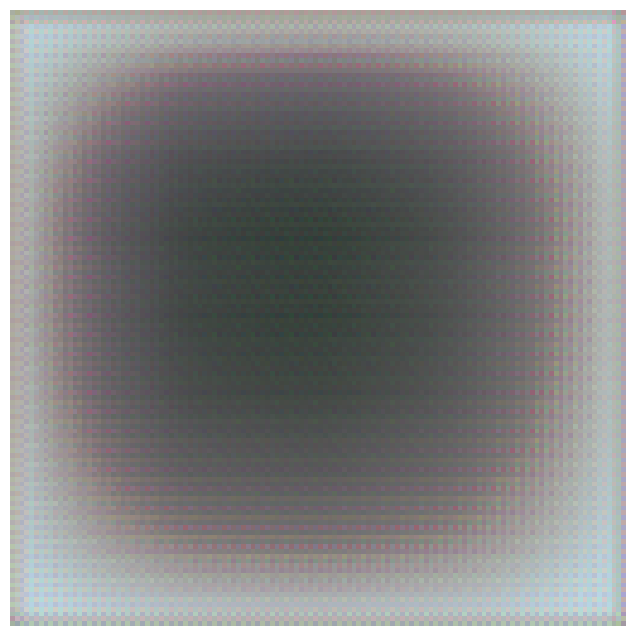

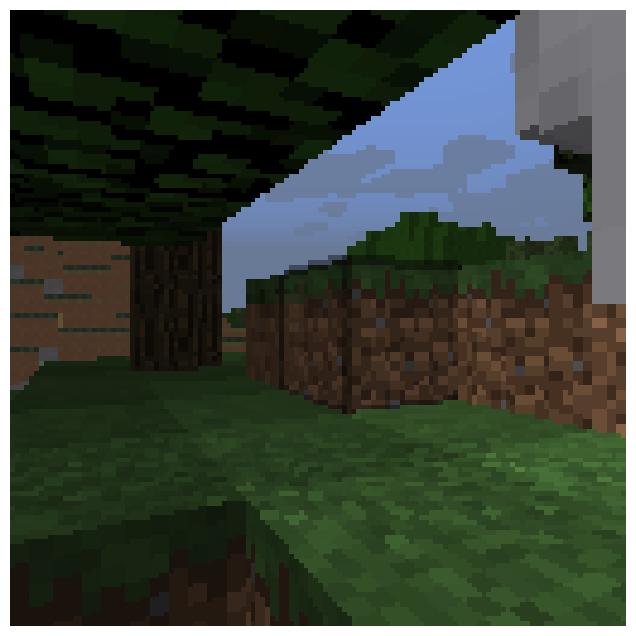

60: 	fm loss=0.6085059642791748
61: ae loss=867.4303588867188
62: ae loss=1230.0498046875
63: ae loss=1238.835205078125
64: ae loss=1020.0986328125
65: 	fm loss=0.5810895562171936
66: ae loss=766.7552490234375
67: ae loss=648.0526123046875
68: ae loss=611.96826171875
69: ae loss=610.1676025390625
70: 	fm loss=0.5611572861671448
71: ae loss=624.442138671875
72: ae loss=636.9849853515625
73: ae loss=710.145263671875
74: ae loss=807.3555908203125
75: 	fm loss=0.5569122433662415
76: ae loss=886.2979125976562
77: ae loss=857.839599609375
78: ae loss=795.6329345703125
79: ae loss=730.7689819335938
80: 	fm loss=0.556052565574646
81: ae loss=589.50537109375
82: ae loss=556.71630859375
83: ae loss=571.6396484375
84: ae loss=563.3226318359375
85: 	fm loss=0.5267393589019775
86: ae loss=545.73486328125
87: ae loss=524.57421875
88: ae loss=485.947509765625
89: ae loss=495.0445251464844
90: 	fm loss=0.5237639546394348
91: ae loss=630.0460205078125
92: ae loss=743.203125
93: ae loss=826.694580078125

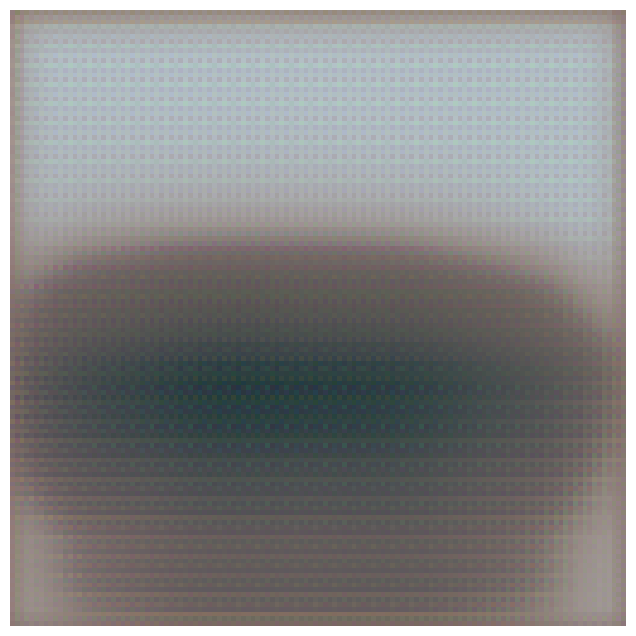

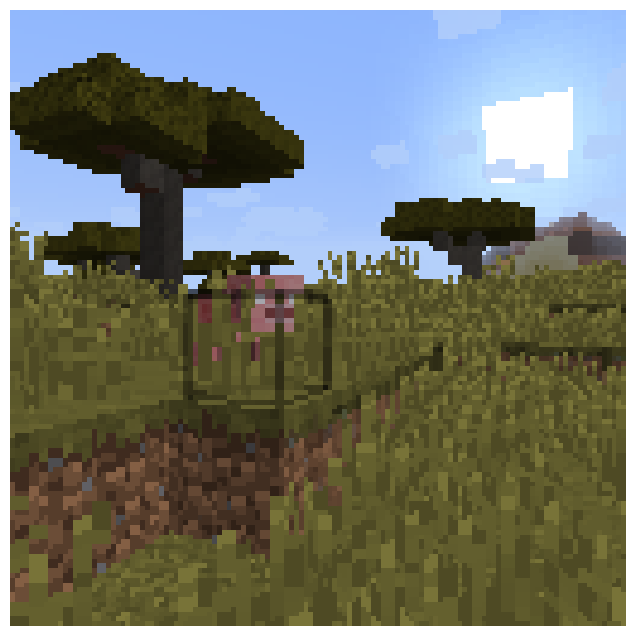

120: 	fm loss=0.5138821601867676
121: ae loss=2294.31494140625
122: ae loss=2145.75439453125
123: ae loss=1957.121337890625
124: ae loss=1845.5106201171875
125: 	fm loss=0.4906730353832245
126: ae loss=1794.39990234375
127: ae loss=1769.16064453125
128: ae loss=1755.7261962890625
129: ae loss=1712.467041015625
130: 	fm loss=0.4959004521369934
131: ae loss=1303.4625244140625
132: ae loss=1136.7529296875
133: ae loss=981.2844848632812
134: ae loss=925.139404296875
135: 	fm loss=0.49132150411605835
136: ae loss=1005.6629028320312
137: ae loss=1111.562744140625
138: ae loss=620.5477294921875
139: ae loss=369.365478515625
140: 	fm loss=0.44998809695243835
141: ae loss=435.7372131347656
142: ae loss=361.98809814453125
143: ae loss=447.1606750488281
144: ae loss=651.1743774414062
145: 	fm loss=0.4569012522697449
146: ae loss=690.868408203125
147: ae loss=656.0863647460938
148: ae loss=411.6365051269531
149: ae loss=322.20404052734375
150: 	fm loss=0.4457721710205078
151: ae loss=670.225952148

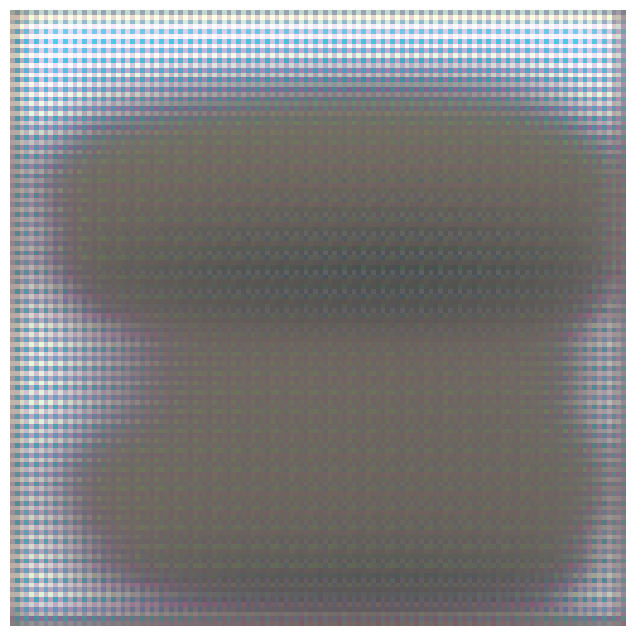

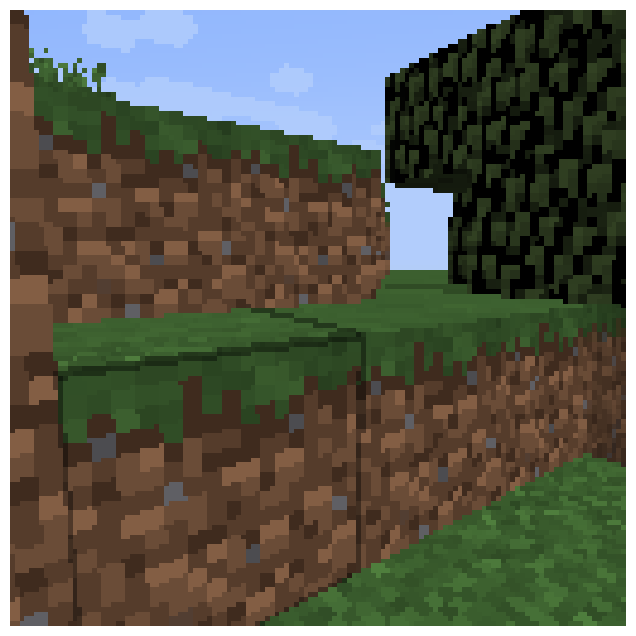

180: 	fm loss=0.4469543695449829
181: ae loss=1675.1591796875
182: ae loss=1617.875732421875
183: ae loss=1562.3798828125
184: ae loss=1503.2113037109375
185: 	fm loss=0.40651562809944153
186: ae loss=1416.787353515625
187: ae loss=1350.8984375
188: ae loss=1299.2744140625
189: ae loss=1267.887451171875
190: 	fm loss=0.389595091342926
191: ae loss=1265.892333984375
192: ae loss=1281.65087890625
193: ae loss=1294.9476318359375
194: ae loss=1310.39453125
195: 	fm loss=0.3856477737426758
196: ae loss=1325.558837890625
197: ae loss=1307.982666015625
198: ae loss=1278.3917236328125
199: ae loss=1242.7421875
200: 	fm loss=0.3820628225803375
201: ae loss=1202.85009765625
202: ae loss=1196.592529296875
203: ae loss=1196.1173095703125
204: ae loss=1197.095458984375
205: 	fm loss=0.3891957402229309
206: ae loss=1185.585693359375
207: ae loss=1166.248046875
208: ae loss=1145.414306640625
209: ae loss=1115.6966552734375
210: 	fm loss=0.36390921473503113
211: ae loss=1109.8272705078125
212: ae loss

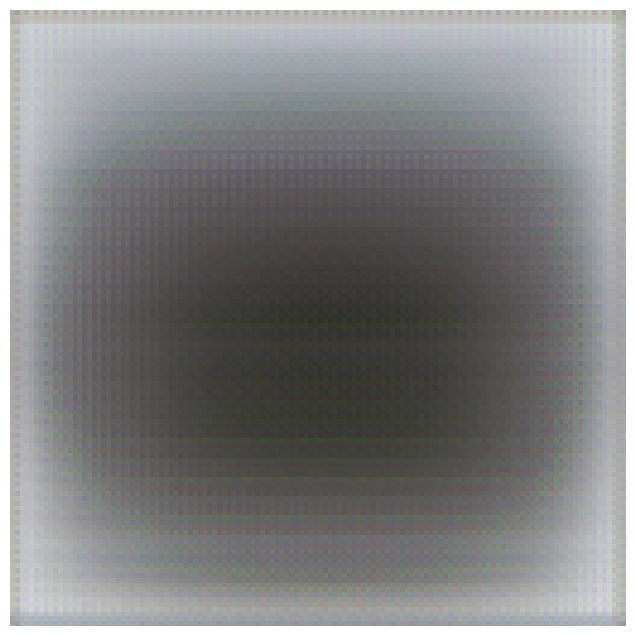

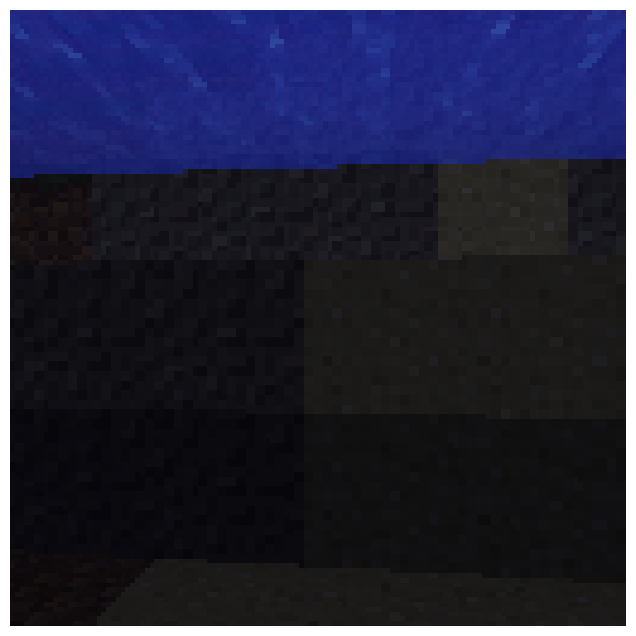

240: 	fm loss=0.37575602531433105
241: ae loss=509.06585693359375
242: ae loss=513.9649047851562
243: ae loss=510.0589294433594
244: ae loss=504.94580078125
245: 	fm loss=0.3338344395160675
246: ae loss=382.9706726074219
247: ae loss=435.4954528808594
248: ae loss=518.2770385742188
249: ae loss=556.7166748046875
250: 	fm loss=0.3539623022079468
251: ae loss=408.18243408203125
252: ae loss=376.88079833984375
253: ae loss=367.976318359375
254: ae loss=465.8385009765625
255: 	fm loss=0.33254462480545044
256: ae loss=529.0963745117188
257: ae loss=513.602294921875
258: ae loss=499.0155029296875
259: ae loss=480.8704833984375
260: 	fm loss=0.3171692490577698
261: ae loss=463.7110290527344
262: ae loss=460.16998291015625
263: ae loss=446.698974609375
264: ae loss=373.3830871582031
265: 	fm loss=0.3271433115005493
266: ae loss=466.39306640625
267: ae loss=441.03363037109375
268: ae loss=434.8201904296875
269: ae loss=418.9430236816406
270: 	fm loss=0.3117976188659668
271: ae loss=530.48913574

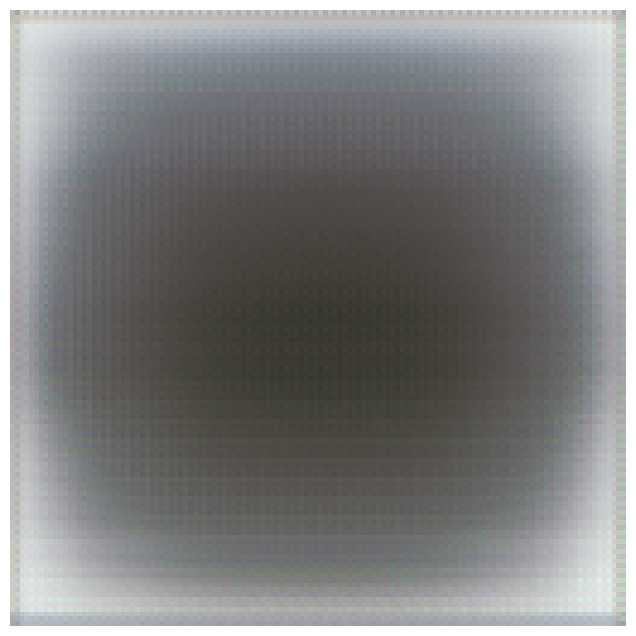

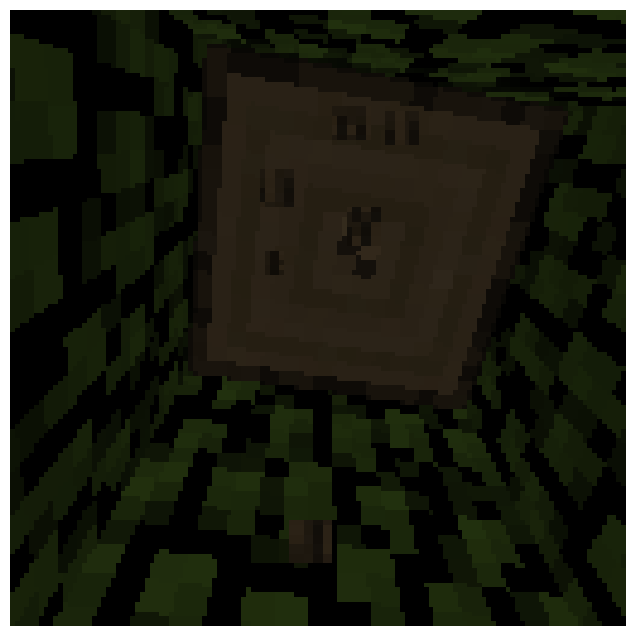

300: 	fm loss=0.32230162620544434
301: ae loss=390.64239501953125
302: ae loss=388.664306640625
303: ae loss=391.8828125
304: ae loss=393.61865234375
305: 	fm loss=0.2775695323944092
306: ae loss=380.64599609375
307: ae loss=383.63763427734375
308: ae loss=422.493408203125
309: ae loss=479.7322998046875
310: 	fm loss=0.26534658670425415
311: ae loss=538.8645629882812
312: ae loss=509.77789306640625
313: ae loss=444.2580261230469
314: ae loss=384.34625244140625
315: 	fm loss=0.27637696266174316
316: ae loss=643.7327880859375
317: ae loss=752.9876098632812
318: ae loss=744.5841674804688
319: ae loss=663.5323486328125
320: 	fm loss=0.26923978328704834
321: ae loss=673.06591796875
322: ae loss=705.167724609375
323: ae loss=677.2237548828125
324: ae loss=638.8673095703125
325: 	fm loss=0.2688930034637451
326: ae loss=564.245361328125
327: ae loss=524.028076171875
328: ae loss=499.5007629394531
329: ae loss=468.2659606933594
330: 	fm loss=0.26734459400177
331: ae loss=494.26531982421875
332:

/home/boggsj/anaconda3/envs/torch/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: Error detected in CudnnBatchNormBackward0. Traceback of forward call that caused the error:
  File "/home/boggsj/anaconda3/envs/torch/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/boggsj/anaconda3/envs/torch/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/boggsj/anaconda3/envs/torch/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/boggsj/anaconda3/envs/torch/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/home/boggsj/anaconda3/envs/torch/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/home/boggsj/anaconda3/envs/torch/lib/python3.10/site-packages/tornado/platform/asyncio.py

RuntimeError: Function 'CudnnBatchNormBackward0' returned nan values in its 0th output.

In [11]:
d_pitch = 0.0
d_yaw = -0.1

for j in range(25):
    d_yaw *= -1
    fe_optim.zero_grad()
    pred_optim.zero_grad()
    dec_optim.zero_grad()
    start_mission()
    while not MALMO_HOST.getWorldState().is_mission_running:
        time.sleep(0.1)
    time.sleep(0.1)
    
    MALMO_HOST.sendCommand("jump 1")
    time.sleep(0.1)
    MALMO_HOST.sendCommand("jump 0")

    old_img, old_img_tens, old_agent_data = get_mc_img(False, kornia.color.rgb_to_hsv)
    old_hx = None
    pred_hx = None
    time.sleep(0.1)
    for k in range(60):
        i = j*60 + k
        
#         if i % 10 == 0:
#         d_pitch = math.sin(i*((2*math.pi)/7))/25
        MALMO_HOST.sendCommand(f"turn {d_yaw}")
#         MALMO_HOST.sendCommand(f"pitch {d_pitch}")


        old_features = feat_extractor(old_img_tens)
        new_img, new_img_tens, new_agent_data = get_mc_img(False)
        camera_delta = new_agent_data - old_agent_data
        camera_delta = camera_delta.expand(1, VIDEO_SHAPE[0]//2, VIDEO_SHAPE[1]//2, 7).transpose(2,3).transpose(1,2).to(DEVICE)
        combo = torch.concat([old_features, camera_delta], dim=1)
        predicted = pred(combo)
        truth = feat_extractor(new_img_tens)

        if i % 5 == 0:
            loss_a = loss_fn(truth, predicted)
            loss_a.backward(retain_graph=False)
            fe_optim.step()
            pred_optim.step()
            print(f"{i}: \tfm loss={loss_a.item()}")
        else:
            dec_old, old_hx = decoder(old_features, old_hx)
            dec_pred, pred_hx = decoder(predicted, pred_hx)
            old_hx = old_hx.detach()
            pred_hx = pred_hx.detach()
        
            loss_b = weighted_loss(loss_fn_2, new_img_tens, dec_pred)
#             loss_b = loss_fn_2(new_img_tens, dec_pred)
            loss_b.backward(retain_graph=False)
            dec_optim.step()
            pred_optim.step()
            fe_optim.step()
            print(f"{i}: ae loss={loss_b.item()}")
            fe_optim.zero_grad()
            pred_optim.zero_grad()
            dec_optim.zero_grad()
        old_img_tens = new_img_tens
        old_agent_data = new_agent_data
        
        if not MALMO_HOST.getWorldState().is_mission_running:
            break
        time.sleep(0.1)
    draw_image(dec_pred, show=True)
    draw_image(new_img_tens, show=True)

In [ ]:
new_img_tens.shape

In [ ]:
dec_pred.shape

In [ ]:
decoder(predicted).shape

In [ ]:
MALMO_HOST.sendCommand("turn 0")
MALMO_HOST.sendCommand("pitch 0")

In [ ]:
dec_pred_img = dec_pred.detach().cpu().numpy().transpose((0,2,3,1))
plt.imshow(dec_pred_img[0])
plt.show()
plt.close()

In [ ]:
plt.imshow(new_img)
plt.show()
plt.close()

In [ ]:
draw_layers(predicted, show=True)

In [ ]:
draw_layers(truth, show=True)

In [ ]:
draw_layers(truth-predicted, show=True)